# Anagram

Given two strings s and t, return true if t is an anagram of s, and false otherwise.

An Anagram is a word or phrase formed by rearranging the letters of a different word or phrase, typically using all the original letters exactly once.

 

Example 1:

Input: s = "anagram", t = "nagaram"
Output: true

Example 2:

Input: s = "rat", t = "car"
Output: false
 

Constraints:

1 <= s.length, t.length <= 5 * 104
s and t consist of lowercase English letters.
 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras.metrics as metrics

np.random.seed(42)

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
STRING_LENGTH_MAX = 15


def generate_random_word_fixed_length(length=15):
    """Generate a random word of fixed length."""
    return "".join([chr(np.random.randint(97, 123)) for _ in range(length)])


def generate_random_word(min_length=3, max_length=15):
    """Generate a random word of random length between min_length and max_length."""
    return generate_random_word_fixed_length(
        np.random.randint(min_length, max_length + 1)
    )


def encode(text):
    """Encode a string into a vector of integers."""
    encoded = [ord(c) for c in text]
    encoded += [0] * (STRING_LENGTH_MAX - len(encoded))
    return np.array(encoded)


def decode(encoded):
    """Decode a vector of integers into a string."""
    return "".join([chr(int(c)) if c != 0 else "-" for c in encoded])


def is_anagram_test(s, t):
    """Normal way of solving :)"""
    return sorted(s) == sorted(t)


def generate_anagram(word, shuffle_probability=0.9):
    """Generate a random anagram of the input word."""
    anagram = list(word)

    if np.random.rand() < shuffle_probability:
        np.random.shuffle(anagram)

    return "".join(anagram)


def generate_non_anagram(word):
    """Generate a random word that has the *same length* as the input word but is not an anagram of it."""
    while True:
        candidate = generate_random_word_fixed_length(len(word))
        if not is_anagram_test(word, candidate):
            return candidate


def generate_non_anagram_off_by_one(word):
    """Generate the word by randomly altering one character in the input word."""
    while True:
        candidate = list(word)
        idx = np.random.randint(len(word))
        candidate[idx] = chr(np.random.randint(97, 123))
        candidate = "".join(candidate)
        if candidate != word:  # TODO:  and not is_anagram_test(word, candidate):
            return candidate


def generate_training_data_positive(num_samples, words=None):
    """
    Generate training data for positive (i.e., anagram) samples with X and y.
    """

    if words:
        assert len(words) == num_samples

    X = []
    y = []

    for i in range(num_samples):
        word = generate_random_word() if words is None else words[i]
        anagram = generate_anagram(word)

        # Encode the original word and its anagram and append to X
        x_vector = np.concatenate((encode(word), encode(anagram)))

        # Append the vector to X
        X.append(x_vector)

        # Append labels (1 for anagrams)
        y.append(1)

    return np.array(X), np.array(y)


def generate_training_data_negative(num_samples, words=None):
    """
    Generate training data for negative (i.e., non-anagram) samples with X and y.
    """

    if words:
        assert len(words) == num_samples

    X = []
    y = []

    for i in range(num_samples):
        word = generate_random_word() if words is None else words[i]
        non_anagram = generate_non_anagram(word)

        # Encode the original word and its anagram and append to X
        x_vector = np.concatenate((encode(word), encode(non_anagram)))

        # Append the vector to X
        X.append(x_vector)

        # Append labels (0 for non-anagrams)
        y.append(0)

    return np.array(X), np.array(y)


def generate_training_data_negative_off_by_one(num_samples, words=None):
    """
    Generate training data for negative (i.e., non-anagram) samples with X and y. This time,
    the non-anagram is generated by randomly altering one character in the original word.
    """

    if words:
        assert len(words) == num_samples

    X = []
    y = []

    for i in range(num_samples):
        word = generate_random_word() if words is None else words[i]
        non_anagram = generate_non_anagram_off_by_one(word)

        # Encode the original word and its anagram and append to X
        x_vector = np.concatenate((encode(word), encode(non_anagram)))

        # Append the vector to X
        X.append(x_vector)

        # Append labels (0 for non-anagrams)
        y.append(0)

    return np.array(X), np.array(y)


# Generate some training samples
num_samples = 50_000
X_positive, y_positive = generate_training_data_positive(num_samples // 2)
X_negative, y_negative = generate_training_data_negative(num_samples // 4)
(
    X_negative_off_by_one,
    y_negative_off_by_one,
) = generate_training_data_negative_off_by_one(num_samples // 4)

# Concatenate the positive and negative samples
X = np.concatenate((X_positive, X_negative, X_negative_off_by_one))
y = np.concatenate((y_positive, y_negative, y_negative_off_by_one))

In [4]:
generate_non_anagram_off_by_one("ibrahim")

'ibraham'

In [5]:
# Train test split randomly.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(37500, 30) (12500, 30) (37500,) (12500,)


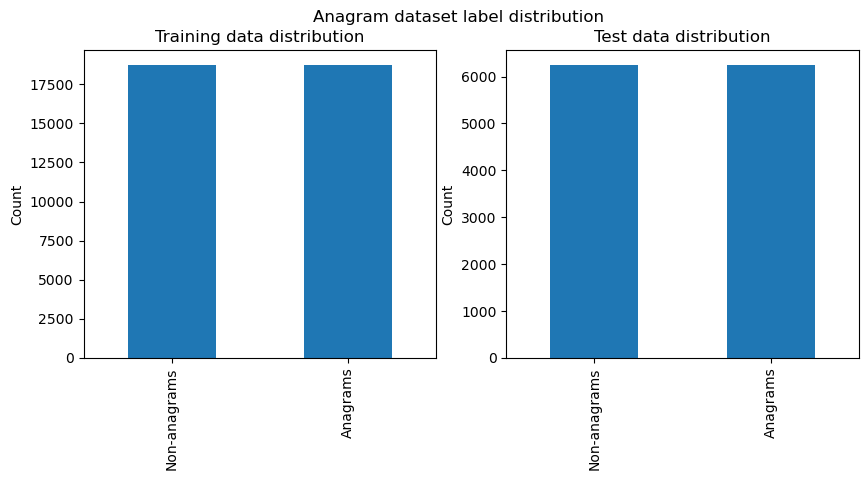

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot training data distribution
pd.Series(y_train).value_counts().plot(kind="bar", ax=ax[0])
ax[0].set_xticklabels(["Non-anagrams", "Anagrams"])
ax[0].set_ylabel("Count")
ax[0].set_title("Training data distribution")

# Plot test data distribution
pd.Series(y_test).value_counts().plot(kind="bar", ax=ax[1])
ax[1].set_xticklabels(["Non-anagrams", "Anagrams"])
ax[1].set_ylabel("Count")
ax[1].set_title("Test data distribution")

plt.suptitle("Anagram dataset label distribution")

plt.show()

In [7]:
learning_rate = 0.001


# Simple model.
# model = tf.keras.Sequential(
#     [
#         tf.keras.layers.Embedding(256, 16, input_length=STRING_LENGTH_MAX * 2),
#         tf.keras.layers.LSTM(32),
#         tf.keras.layers.Dense(1, activation="sigmoid"),
#     ]
# )

# More complex model.
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(
            input_dim=256, output_dim=64, input_length=STRING_LENGTH_MAX * 2
        ),
        # # kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.LSTM(256, return_sequences=True),  
        # tf.keras.layers.Dropout(0.25),  # Adding dropout
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(64, activation="relu"), # , kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        # tf.keras.layers.Dropout(0.25),  # Adding dropout
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)


# Define an optimizer with the learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", metrics.Precision(), metrics.Recall()],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 64)            16384     
                                                                 
 lstm (LSTM)                 (None, 30, 256)           328704    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 550,529
Trainable params: 550,529
Non-trainable params: 0
_________________________________________________________________


In [8]:
# train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
)

Epoch 1/50


1172/1172 [==============================] - 29s 22ms/step - loss: 0.6935 - accuracy: 0.4991 - precision: 0.4992 - recall: 0.4767 - val_loss: 0.6932 - val_accuracy: 0.5011 - val_precision: 0.5003 - val_recall: 0.9861
Epoch 2/50
1172/1172 [==============================] - 28s 24ms/step - loss: 0.5951 - accuracy: 0.6233 - precision: 0.5928 - recall: 0.7882 - val_loss: 0.3504 - val_accuracy: 0.8406 - val_precision: 0.7739 - val_recall: 0.9619
Epoch 3/50
1172/1172 [==============================] - 28s 24ms/step - loss: 0.3033 - accuracy: 0.8685 - precision: 0.8215 - recall: 0.9417 - val_loss: 0.2487 - val_accuracy: 0.8966 - val_precision: 0.8494 - val_recall: 0.9638
Epoch 4/50
1172/1172 [==============================] - 28s 24ms/step - loss: 0.2256 - accuracy: 0.9078 - precision: 0.8689 - recall: 0.9607 - val_loss: 0.1928 - val_accuracy: 0.9208 - val_precision: 0.8868 - val_recall: 0.9646
Epoch 5/50
1172/1172 [==============================] - 28s 24ms/step - loss: 0.2058 - accuracy: 0.

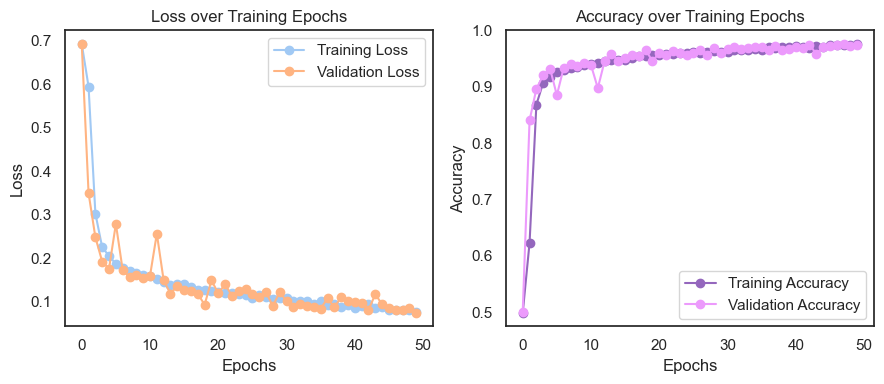

In [9]:
h = history.history

# Set Seaborn theme and style
sns.set_theme(style="white", palette="pastel")


plt.figure(figsize=(9, 4))

# Plot training loss and validation loss
plt.subplot(1, 2, 1)
plt.plot(h["loss"], label="Training Loss", marker="o")
plt.plot(h["val_loss"], label="Validation Loss", marker="o")
plt.title("Loss over Training Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)

plt.plot(h["accuracy"], label="Training Accuracy", marker="o", color="#9467bd")
plt.plot(h["val_accuracy"], label="Validation Accuracy", marker="o", color="#ec9afc")
plt.title("Accuracy over Training Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
def plot_confusion_matrix(
    actual_labels, predicted_labels, labels, title="Confusion Matrix"
):
    cm = confusion_matrix(actual_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

391/391 [==============================] - 4s 7ms/step


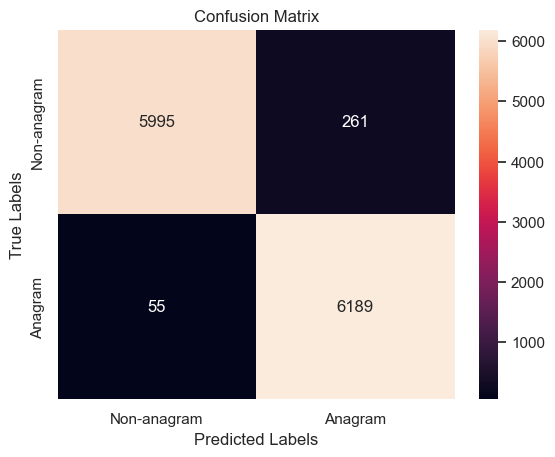

In [11]:
# plot the confusion matrix on the test data
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int).reshape(-1)
plot_confusion_matrix(y_test, y_pred, ["Non-anagram", "Anagram"])

In [12]:
# inspect 5 test samples from the test set
sample_indices = np.random.choice(range(len(X_test)), 5)
X_sample = X_test[sample_indices]
y_sample = y_test[sample_indices]
y_sample_pred = np.round(model.predict(X_sample)).astype(int).reshape(-1)
X_sample_decoded = np.array([decode(x) for x in X_sample])

1/1 [==============================] - 0s 46ms/step


In [13]:
X_sample_decoded

array(['umihybw--------cmlcqio--------', 'hmz------------hmz------------',
       'rrejwh---------hwerjr---------', 'ulzzoapszwl----ulzzoapszwl----',
       'ioubhyax-------yiuxhabo-------'], dtype='<U30')

In [14]:
data = pd.DataFrame(X_sample_decoded, columns=["Word/Anagram"])
data["Word"] = data["Word/Anagram"].apply(lambda x: x[:STRING_LENGTH_MAX])
data["Anagram"] = data["Word/Anagram"].apply(lambda x: x[STRING_LENGTH_MAX:])
data = data.drop(columns=["Word/Anagram"])
data["True_Label"] = y_sample
data["Predicted_Label"] = y_sample_pred
data

,Word,Anagram,True_Label,Predicted_Label
0,umihybw--------,cmlcqio--------,0,0
1,hmz------------,hmz------------,1,1
2,rrejwh---------,hwerjr---------,1,1
3,ulzzoapszwl----,ulzzoapszwl----,1,1
4,ioubhyax-------,yiuxhabo-------,1,1


### Production ready model 🚀

In [15]:
def predict_anagram(word, anagram, model, check_mode=False) -> bool:
    """Predict if a word is an anagram of the input word."""
    x = np.concatenate((encode(word), encode(anagram)))
    y_pred = (
        np.round(
            model.predict(x.reshape(1, -1), verbose=0),
        )
        .astype(int)
        .reshape(-1)
    )

    if check_mode:
        print(f"Prediction: {bool(y_pred)} \tActual: {is_anagram_test(word, anagram)}")
    else:
        return int(y_pred)

In [17]:
predict_anagram(model=model, word="ibrahim", anagram="miharbi", check_mode=True)
predict_anagram(model=model, word="ibrahim", anagram="ibrahimm", check_mode=True)
predict_anagram(model=model, word="ibrahim", anagram="iibbrraahhiimm", check_mode=True)
predict_anagram(model=model, word="ibrahim", anagram="1brah1m", check_mode=True)
predict_anagram(model=model, word="ibrahim", anagram="abraham", check_mode=True)
predict_anagram(model=model, word="ibrahim", anagram="iibrahm", check_mode=True)
predict_anagram(model=model, word="ibrahim", anagram="ibrahmi", check_mode=True)
predict_anagram(model=model, word="ibrahim", anagram="ibrahim", check_mode=True)
predict_anagram(model=model, word="abraham", anagram="abraham", check_mode=True)

Prediction: True 	Actual: True
Prediction: False 	Actual: False
Prediction: False 	Actual: False
Prediction: False 	Actual: False
Prediction: False 	Actual: False
Prediction: True 	Actual: True
Prediction: True 	Actual: True
Prediction: True 	Actual: True
Prediction: True 	Actual: True


## Incorporating the Real Words

In [18]:
# Read the words `colors`
with open("./Anagram/colors_lowercase.txt", "r") as f:
    colors = f.read().split("\n")[:-1]

print(f"{len(colors)} colors read from the file.")

111 colors read from the file.


In [22]:
# generate additional test data of 10 entries, 5 true anagram and 5 false anagram
num_samples = 25
colors_sampled = list(np.random.choice(colors, num_samples // 2))
X_positive_new, y_positive_new = generate_training_data_positive(
    num_samples // 2, colors_sampled
)
X_negative_new, y_negative_new = generate_training_data_negative(
    num_samples // 2, colors_sampled
)

# Concatenate the positive and negative samples
X_new = np.concatenate((X_positive_new, X_negative_new))
y_new = np.concatenate((y_positive_new, y_negative_new))
print(X_new.shape, y_new.shape)


# Show the encoded data (X and y concatenated, having 30 + 1 columns)
display(
    pd.DataFrame(
        np.concatenate((X_new, y_new.reshape(-1, 1)), axis=1),
        columns=[f"Chr_{i}" for i in range(30)] + ["Label"],
    )
)

X_sample_decoded = np.array([decode(x) for x in X_new])
data = pd.DataFrame(X_sample_decoded, columns=["Word/Anagram"])
data["Word"] = data["Word/Anagram"].apply(lambda x: x[:STRING_LENGTH_MAX])
data["Anagram"] = data["Word/Anagram"].apply(lambda x: x[STRING_LENGTH_MAX:])
data = data.drop(columns=["Word/Anagram"])
data["Prediction"] = data.apply(
    lambda x: predict_anagram(x["Word"], x["Anagram"], model), axis=1
)
data["True_Label"] = y_new
data

(24, 30) (24,)


,Chr_0,Chr_1,Chr_2,Chr_3,Chr_4,Chr_5,Chr_6,Chr_7,Chr_8,Chr_9,...,Chr_21,Chr_22,Chr_23,Chr_24,Chr_25,Chr_26,Chr_27,Chr_28,Chr_29,Label
0,109,105,100,110,105,103,104,116,0,0,...,116,109,0,0,0,0,0,0,0,1
1,116,97,110,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,115,97,98,108,101,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,109,105,100,110,105,103,104,116,0,0,...,100,109,0,0,0,0,0,0,0,1
4,97,108,111,101,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,109,97,114,111,111,110,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,105,110,100,105,103,111,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,109,105,110,116,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,99,121,97,110,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,109,97,104,111,103,97,110,121,0,0,...,110,104,0,0,0,0,0,0,0,1


,Word,Anagram,Prediction,True_Label
0,midnight-------,gidinhtm-------,1,1
1,tan------------,atn------------,1,1
2,sable----------,elsab----------,1,1
3,midnight-------,inhgitdm-------,1,1
4,aloe-----------,aloe-----------,1,1
5,maroon---------,mraoon---------,1,1
6,indigo---------,dogiin---------,1,1
7,mint-----------,tinm-----------,1,1
8,cyan-----------,ancy-----------,1,1
9,mahogany-------,ayogmanh-------,1,1
